### Initial Modeling

Like what I've remarked before, not that I will 'recycle' this code for running subsequent versions of data.
I would still like to make a second and fancier version of this project, and likely that would be in its own
notebook, but for now:

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as ss

In [138]:
from nltk.corpus import stopwords
import regex as re

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier

import warnings #Idea from Ben Moss of our GA cohort - thank you! Just to make tuning easier on our eyes...
warnings.simplefilter(action='ignore', category=FutureWarning);

import pickle

In [18]:
df = pd.read_csv('data/cleaned_reddits.csv') #Importing our cleanned data. See the EDA notebook for 
#details how we got here.
print(df.shape)

(9100, 12)


The plan going forward is to start with cleaned title analysis. Although in the first iteration of this project I initially started with the cleaned post, when there is already such a difference in their lengths (via the abscence of actual posts in lieu of pictures and the like in the r/manga) we'll skip to cleaned_titles already.

In [26]:
X = df['cleaned_title']
y = df['subreddit']

In [27]:
#Let's go ahead and make our train/test split.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2, #Perhaps subject to change, but we'll go with it for now
                                                    random_state = 26, #Recall that I like this number
                                                    stratify=y) #To be safe... recall that it's 50/50

In [28]:
#Potentially not the most relevant here, but I'd like to get a taste of common words before any additional steps are taken.
cvec_ex = CountVectorizer(stop_words='english') #We'll at least get rid of English stopwords
X_train_cvec_ex = cvec_ex.fit_transform(X_train)

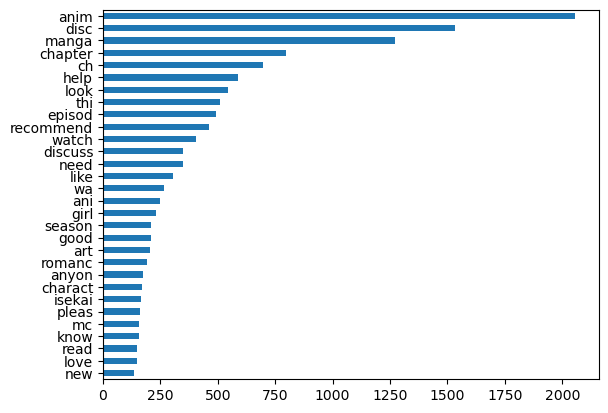

In [29]:
X_train_ex = pd.DataFrame(X_train_cvec_ex.todense(), #Just to gt a feel for the data. Most are unsurprising.
                          columns=cvec_ex.get_feature_names_out())

X_train_ex.sum().sort_values().tail(30).plot(kind="barh");

In [30]:
#So, a number are not surprising. Most importantly are the two subreddits themselvs, representing each other's medium.
#To show the folloiwng before continuing to comment:
print('anim')
print(df[df['cleaned_title'].str.contains('anim')]['subreddit'].value_counts(normalize=True))
print('~'*26)
print('manga')
print(df[df['cleaned_title'].str.contains('manga')]['subreddit'].value_counts(normalize=True))

#I would like to clarify that I'm gauging frequency in just the raw occurence of a word as opposed to word count, as
#I'm interested in seeing just the raw presence of one word over another in any post, let alone its scale, to try to gauge
#the presence or lack there of, of words.

anim
subreddit
1    0.983065
0    0.016935
Name: proportion, dtype: float64
~~~~~~~~~~~~~~~~~~~~~~~~~~
manga
subreddit
0    0.955446
1    0.044554
Name: proportion, dtype: float64


In [32]:
#I also feel like exploring this one:

print('http')
print(df[df['cleaned_title'].str.contains('http')]['subreddit'].value_counts(normalize=True))

http
subreddit
0    1.0
Name: proportion, dtype: float64


In [ ]:
#POTENTIAL DATA TO USE...

In [ ]:
for i in range(5):
    print(current_train_words.sum().sort_values(ascending=False).reset_index()['index'][i]) #Shoutout once again to Dori from Stackoverflow re. getting the index out of a value counted type thing. 
    print(df[df['cleaned_post'].str.contains(current_train_words.sum().sort_values(ascending=False).reset_index()['index'][i])]['subreddit'].value_counts(normalize=True))
    print('~'*26)
#Although the first four are all stop words, their inclination towards anime add up, especially as despite having the option
#to use English stop words, CV determined their presence was actually useful in identifying one class over the other.
#This is consistent with our theory of basically any words are more likely to denotate anime as just many more words
#are being used.

In [ ]:
#Let's try to hone in on the words that predominate mangas [without considering mutual frequency in anime]:
current_train_words['subreddit'] = y_train.reset_index(drop=True)

#For manga, which is of greater interest to me considering that most of the 'posts' we just used their titles.
current_train_words[current_train_words['subreddit']==0].sum().sort_values().tail(30).plot(kind="barh");
#So, we see many overlaps. Off hand what stands out is manga, DISC, chapter, and read. Let's try something else though:

In [ ]:
#Although their frequencies in manga appear above, let's see how many are actually in a majority of manga posts.
thresh, dict_of_word_proportions = .33, [] #Representing that a word is at least twice as frequent in manga.
for i in range(400): #Should work on this code, as it's making an interesting 'Key Error: 1' if the range is too big
    handle = current_train_words.sum().sort_values(ascending=False).reset_index()['index'][i]
    base = df[df['cleaned_post'].str.contains(handle)]['subreddit'].value_counts(normalize=True)
    try:
        if base[0] - base[1] >= thresh:
            dict_of_word_proportions.append({
                'current_tier':i,
                'word':handle,
                'm_count':df[df['cleaned_post'].str.contains(handle)]['subreddit'].value_counts(normalize=True)[0]
            })
    except:
        pass
print(len(dict_of_word_proportions))

In [ ]:
dict_of_word_proportions  #So, it took 400 words to finally get a third word that is dominately in the manga camp.
#Note that 'manhwa' is a term for Korean manga, so arguably the same word as 'manga' for the sake of simplication.

In [ ]:
#Meanwhile, with anime:
thresh, dict_of_word_proportions = .33, [] #Representing that a word is at least twice as frequent in manga.
for i in range(400): #Should work on this code, as it's making an interesting 'Key Error: 1' if the range is too big
    handle = current_train_words.sum().sort_values(ascending=False).reset_index()['index'][i]
    base = df[df['cleaned_post'].str.contains(handle)]['subreddit'].value_counts(normalize=True)
    try:
        if base[1] - base[0] >= thresh:
            dict_of_word_proportions.append({
                'current_tier':i,
                'word':handle,
                'm_count':df[df['cleaned_post'].str.contains(handle)]['subreddit'].value_counts(normalize=True)[0]
            })
    except:
        pass
print(len(dict_of_word_proportions))
#And this is unsurprising given our observations on word counts.

### Logistic Regression Modeling

#To retain some comments from the first iteration re. switching to title focus::

#Although our model earlier is clearly overfit, I have no interest in parameter tuning a model that already did so well, 
#nor even gauging other models' performances when I suspect and observe the following:

#The sheer discrepancy between the reality of most manga posts are being represented in this analysis by their titles.
#Hence, the the median and mean of anime being over 50 words greater than that of anime (see earlier).
#Perforce, any conclusions reached would be dubious at best for the company as it's not a direct comparison of WORDS used 
#by the two subreddits, but a difference in their culture. And, while that could be justified by then including tendencies 
#to post pictues and the like, it too greatly strays away from the company's request to focus on their words.
#Titles, however, would seem to be an appropriate comparison, not only in content (words) but they are of near identical
#mean and medium (earlier).

#Continuing. So, although we've yet to 'properly fit' even this model, I feel remarkably little justification for
#the sake of exploring NLP where even stop words are fit to be included on the basis of their ovewhelming predictive powe,
#Seemingly just on the basis that anime posts are 'actual posts' while the 'posts' from manga are mostly their titles.

#We'll repeat the entertaiing, at least for me, exercise of word frequency/category later on.

#So, I will now examine their titles and see if we can make an accurate distinction between the two of them:
#Recall that the average manga and anime posts were approximately 9 and 9.3 words in length.

In [ ]:
#See below:
#So, our goal is to prune as many as such words as possible:
eng_stop_words = stopwords.words('english')
eng_stop_words = [re.sub("[^a-zA-Z]",'', eng_stop_words[i]) for i in range(len(eng_stop_words))]
eng_stop_words.append("I")
words_to_add = ['manga', 'anime', 'anim']
#We'll leave it at the main ones for now, as with our current proposal I can't justify removing wods that are not essentially
#just the identifyiers. Reminder that we are currently just analyzing titles.

#words_to_consider = ['episod', 'chapter', 'season', 'anim', 'ani', 'show', 'watch', 'read', 'myanimelist', 
#                     'anilist', 'crunchyrol', 'myanimelist net', 'rewatch', 'stream', 'ch']
#words_to_ponder = ['http', 'com', 'disc', 'link', 'www', 'redd', 'wa', 'net', 'reddit', 'reddit cmment', 
#                   'anidb', 'png', 'github']
#Consiring also adding 'ani' which was likely a shortened version of 'anime', but we'll leave it for now:

In [ ]:
complete_stop = eng_stop_words.copy() #Still odd that we have to use .copy() as otherwise the two would mimmic each other.
for i in range(len(words_to_add)):
    complete_stop.append(words_to_add[i])
#for i in range(len(words_to_consider)):
#    complete_stop.append(words_to_consider[i])
#for i in range(len(words_to_ponder)):
#    complete_stop.append(words_to_ponder[i])
print(len(complete_stop), len(eng_stop_words))

I'll post here a copy of the initial parameters chosen to tune for and my thoughts on each one so the reader gets a feel for my thought process. However, I won't bother to copy every single iteration; whatever shown in the code will be the final round of that model's hyperparameter tuning. I will on principle keep all parameter's experimented with inplace for the reader to notice. Ie despite even in this example me not bothering to experiment with cvec's min_df I still would like to retain it as often I would play around with it.

Regardless, here we go: <br>
<br>
pipe = Pipeline([ <br>
    ('cvec', CountVectorizer(lowercase=False)),<br>
    ('lr', LogisticRegression(max_iter=2500))<br>
])<br>
pipe_params = {'cvec__min_df' : [0.0]<br>
               ,'cvec__max_df' : [.95, .975, 1.0]<br>
               ,'cvec__ngram_range' : [(1, 1), (1,2), (1,3)]<br>
               ,'cvec__max_features' : [800, 1200, 1600, 2000]<br>
               ,'cvec__stop_words' : ['english', None]<br>
               ,'lr__C' : [1.0, .95, .9]
              }<br>
gs_lrcv = GridSearchCV(pipe,<br>
                  param_grid=pipe_params,<br>
                  cv=5)<br>
<br>
0.9737637362637362 0.9280219780219781 (train and test scores) <br>
0.9354395604395604 (cv's best score) <Br>
{'cvec__max_df': 0.95, 'cvec__max_features': 2000, 'cvec__min_df': 0.0, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'lr__C': 0.9}

Seeing that the minimum max df was chosen we'll likely continue experimenting with that. 2000 features were chosen so we'll
naturally go towards that direction, increasing the threshold. Interestingly, ngrams used were still 11. On principleI'll at least keep 1,2. Also intrigued that we opted out of filtering stop words, perhaps accounted for by cultural differencens in the current epoch between the two of them. And finally, we'll explore more C's in lr as well.

In [69]:
pipe = Pipeline([
    ('cvec', CountVectorizer(lowercase=False)),
    ('lr', LogisticRegression(max_iter=2500))
])
pipe_params = {'cvec__min_df' : [0.0]
               ,'cvec__max_df' : [.95]
               ,'cvec__ngram_range' : [(1, 1)]
               ,'cvec__max_features' : [325, 350]
               ,'cvec__stop_words' : [None, 'english']
               ,'lr__C' : [.88]
              }
gs_lrcv = GridSearchCV(pipe,
                  param_grid=pipe_params,
                  cv=5)

gs_lrcv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(lowercase=False)),
                                       ('lr',
                                        LogisticRegression(max_iter=2500))]),
             param_grid={'cvec__max_df': [0.95],
                         'cvec__max_features': [325, 350],
                         'cvec__min_df': [0.0], 'cvec__ngram_range': [(1, 1)],
                         'cvec__stop_words': [None, 'english'],
                         'lr__C': [0.88]})

In [70]:
print(gs_lrcv.score(X_train, y_train), gs_lrcv.score(X_test, y_test))
print(gs_lrcv.best_score_)
print(gs_lrcv.best_params_)

0.9460164835164835 0.9203296703296703
0.926510989010989
{'cvec__max_df': 0.95, 'cvec__max_features': 350, 'cvec__min_df': 0.0, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'lr__C': 0.88}


Although from the initial pull we were inclined to add more and more features, train accuracy marginally went up. At approximately 2800, with the accuacy still being in the .92s, I decided the additional features and cvecs ranges being desired were not justified. So, I minimized the model as much as  could, while stil feeling like maintaining the .92% accuracy.

In [92]:
#Anyways, it's time for LR to meet Tiffany:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(lowercase=False)),
    ('lr', LogisticRegression(max_iter=3000))
])
pipe_params = {'tvec__min_df' : [.0]
               ,'tvec__max_df' : [1.0]
               ,'tvec__ngram_range' : [(1,1)]
               ,'tvec__max_features' : [1200, 1100]
               ,'tvec__stop_words' : [None]
               ,'lr__C' : [.95]
               }
gs_lrtv = GridSearchCV(pipe,
                  param_grid=pipe_params,
                  cv=5)

gs_lrtv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(lowercase=False)),
                                       ('lr',
                                        LogisticRegression(max_iter=3000))]),
             param_grid={'lr__C': [0.95], 'tvec__max_df': [1.0],
                         'tvec__max_features': [1200, 1100],
                         'tvec__min_df': [0.0], 'tvec__ngram_range': [(1, 1)],
                         'tvec__stop_words': [None]})

In [93]:
print(gs_lrtv.score(X_train, y_train), gs_lrtv.score(X_test, y_test))
print(gs_lrtv.best_score_)
print(gs_lrtv.best_params_)

0.9587912087912088 0.9302197802197802
0.9387362637362638
{'lr__C': 0.95, 'tvec__max_df': 1.0, 'tvec__max_features': 1200, 'tvec__min_df': 0.0, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}


Akin to earlier, models desired more features, yet wth a negligible increase in test accuracy I did not bother to keep them.

However, observe: Albeit we have an increased accuracy in Tiffany, which seemed justified per the defaults, we're ultimately now using more feautres. I did not bother to go down to 350 to compare, but the point remains that Tiffany requires a lot more features than Cvec.

### Naive Bayes

In [98]:
#Now let us move onto MNB. Starting with cvec:
pipe = Pipeline([
    ('cvec', CountVectorizer(lowercase=False)),
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)), #Thanks to Stackoverflow's Spirit of the Void
    ('mnb', MultinomialNB())
])
pipe_params = {'cvec__min_df' : [.0]
               ,'cvec__max_df' : [.975]
               ,'cvec__ngram_range' : [(1,2),(1,3)]
               ,'cvec__max_features' : [3000, 3500]
               ,'cvec__stop_words' : ['english']
               ,'mnb__alpha': [.95]
              }
gs_mnbcv = GridSearchCV(pipe,
                  param_grid=pipe_params,
                  cv=5)
gs_mnbcv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(lowercase=False)),
                                       ('to_dense',
                                        FunctionTransformer(accept_sparse=True,
                                                            func=<function <lambda> at 0x0000024653FE4360>)),
                                       ('mnb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.975],
                         'cvec__max_features': [3000, 3500],
                         'cvec__min_df': [0.0],
                         'cvec__ngram_range': [(1, 2), (1, 3)],
                         'cvec__stop_words': ['english'],
                         'mnb__alpha': [0.95]})

In [99]:
print(gs_mnbcv.score(X_train, y_train), gs_mnbcv.score(X_test, y_test))
print(gs_mnbcv.best_score_)
print(gs_mnbcv.best_params_)

#Perhaps I'm leaving things half-baked, however with many more features and a negligible increase from logreg (comparing to the same
#cvec tokenization) I've had enough. Of note though is the lesser discrepancy between test and train, albeit still overfit.

#Recall by the way in the first iteration of this project that this was the mdoel chosen... likely we have 94% via using
#a gazillion features.... so, let's see if we can work upon it. For whatever it matters though: Our data is so much more robust and
#meaningful now, being over 3x and UNIQUE values compared to the original...

0.946565934065934 0.9252747252747253
0.9320054945054945
{'cvec__max_df': 0.975, 'cvec__max_features': 3500, 'cvec__min_df': 0.0, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english', 'mnb__alpha': 0.95}


In [102]:
#Let's go to Tiffany now:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(lowercase=False)),
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)), #Thanks to Stackoverflow's Spirit of the Void
    ('mnb', MultinomialNB())
])
pipe_params = {'tvec__min_df' : [.05]
               ,'tvec__max_df' : [.95, .975,1.0]
               ,'tvec__ngram_range' : [(1,1), (1,2)]
               ,'tvec__max_features' : [800, 1200, 1600]
               ,'tvec__stop_words' : [None]
               ,'mnb__alpha' : [.9, .95, 1.0]
              }
gs_mnbtv = GridSearchCV(pipe,
                  param_grid=pipe_params,
                  cv=5)
gs_mnbtv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(lowercase=False)),
                                       ('to_dense',
                                        FunctionTransformer(accept_sparse=True,
                                                            func=<function <lambda> at 0x0000024653FE42C0>)),
                                       ('mnb', MultinomialNB())]),
             param_grid={'mnb__alpha': [0.9, 0.95, 1.0],
                         'tvec__max_df': [0.95, 0.975, 1.0],
                         'tvec__max_features': [800, 1200, 1600],
                         'tvec__min_df': [0.05],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None]})

In [103]:
print(gs_mnbtv.score(X_train, y_train), gs_mnbtv.score(X_test, y_test)) #Yeah, that didn't do anything.
print(gs_mnbtv.best_score_)
print(gs_mnbtv.best_params_)

#In short, re. gs_mnbtv's selection: Despite having a small difference between train and test, honestly I think the smallest
#from mental math, the much lower prediction rates compared to the others, especially when we used CVec with MNB, that
#this will not be selected.

0.8755494505494505 0.8730769230769231
0.8759615384615383
{'mnb__alpha': 0.9, 'tvec__max_df': 0.95, 'tvec__max_features': 800, 'tvec__min_df': 0.05, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}


In [105]:
#Might as well at least try the other NBs:
pipe = Pipeline([
    ('cvec', CountVectorizer(lowercase=False)),
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)), #Thanks to Stackoverflow's Spirit of the Void
    ('gnb', GaussianNB())
])
pipe_params = {'cvec__min_df' : [.0]
               ,'cvec__max_df' : [.975]
               ,'cvec__ngram_range' : [(1,1), (1,2),(1,3)]
               ,'cvec__max_features' : [2500, 3000, 3500]
               ,'cvec__stop_words' : ['english', None]
              }
gs = GridSearchCV(pipe, #Note the change from gs_name to just gs... thesemodels are small so eh, let's make the coding easier.
                  param_grid=pipe_params,
                  cv=5)
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(lowercase=False)),
                                       ('to_dense',
                                        FunctionTransformer(accept_sparse=True,
                                                            func=<function <lambda> at 0x00000246569463E0>)),
                                       ('gnb', GaussianNB())]),
             param_grid={'cvec__max_df': [0.975],
                         'cvec__max_features': [2500, 3000, 3500],
                         'cvec__min_df': [0.0],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'cvec__stop_words': ['english', None]})

In [106]:
print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_) #Eh, lackluster... worth a shot though. I won't even bother as we've already found a model that is
#approximately the same train/test as well as having a model with a much higher accuracy...

0.923489010989011 0.8730769230769231
0.8743131868131867
{'cvec__max_df': 0.975, 'cvec__max_features': 3500, 'cvec__min_df': 0.0, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english'}


In [113]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(lowercase=False)),
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)), #Thanks to Stackoverflow's Spirit of the Void
    ('gnb', GaussianNB())
])
pipe_params = {'tvec__min_df' : [.05]
               ,'tvec__max_df' : [.95, .975,1.0]
               ,'tvec__ngram_range' : [(1,1), (1,2)]
               ,'tvec__max_features' : [800, 1200, 1600]
               ,'tvec__stop_words' : [None]
              }
gs = GridSearchCV(pipe,
                  param_grid=pipe_params,
                  cv=5)
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(lowercase=False)),
                                       ('to_dense',
                                        FunctionTransformer(accept_sparse=True,
                                                            func=<function <lambda> at 0x0000024653FE4220>)),
                                       ('gnb', GaussianNB())]),
             param_grid={'tvec__max_df': [0.95, 0.975, 1.0],
                         'tvec__max_features': [800, 1200, 1600],
                         'tvec__min_df': [0.05],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None]})

In [114]:
print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_) #Hmm, interesting... Yeah, won't bother...

0.8377747252747253 0.839010989010989
0.8321428571428571
{'tvec__max_df': 0.95, 'tvec__max_features': 800, 'tvec__min_df': 0.05, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}


In [109]:
#Complement time
pipe = Pipeline([
    ('cvec', CountVectorizer(lowercase=False)),
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)), #Thanks to Stackoverflow's Spirit of the Void
    ('cnb', ComplementNB())
])
pipe_params = {'cvec__min_df' : [.0]
               ,'cvec__max_df' : [.975]
               ,'cvec__ngram_range' : [(1,2),(1,3)]
               ,'cvec__max_features' : [4000, 3500]
               ,'cvec__stop_words' : ['english']
               ,'cnb__alpha': [1.0]
              }
gs = GridSearchCV(pipe, #Note the change from gs_name to just gs... thesemodels are small so eh, let's make the coding easier.
                  param_grid=pipe_params,
                  cv=5)
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(lowercase=False)),
                                       ('to_dense',
                                        FunctionTransformer(accept_sparse=True,
                                                            func=<function <lambda> at 0x0000024653FE6700>)),
                                       ('cnb', ComplementNB())]),
             param_grid={'cnb__alpha': [1.0], 'cvec__max_df': [0.975],
                         'cvec__max_features': [4000, 3500],
                         'cvec__min_df': [0.0],
                         'cvec__ngram_range': [(1, 2), (1, 3)],
                         'cvec__stop_words': ['english']})

In [110]:
print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)

#Potetially should go back to this one.... much narrower gap and still nice trainn..

0.9490384615384615 0.926923076923077
0.9336538461538462
{'cnb__alpha': 1.0, 'cvec__max_df': 0.975, 'cvec__max_features': 4000, 'cvec__min_df': 0.0, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english'}


In [115]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(lowercase=False)),
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)), #Thanks to Stackoverflow's Spirit of the Void
    ('cnb', ComplementNB())
])
pipe_params = {'tvec__min_df' : [.05]
               ,'tvec__max_df' : [.95, .975,1.0]
               ,'tvec__ngram_range' : [(1,1), (1,2)]
               ,'tvec__max_features' : [800, 1200, 1600]
               ,'tvec__stop_words' : [None]
               ,'cnb__alpha' : [.9, .95, 1.0]
              }
gs = GridSearchCV(pipe,
                  param_grid=pipe_params,
                  cv=5)
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(lowercase=False)),
                                       ('to_dense',
                                        FunctionTransformer(accept_sparse=True,
                                                            func=<function <lambda> at 0x0000024652AB4A40>)),
                                       ('cnb', ComplementNB())]),
             param_grid={'cnb__alpha': [0.9, 0.95, 1.0],
                         'tvec__max_df': [0.95, 0.975, 1.0],
                         'tvec__max_features': [800, 1200, 1600],
                         'tvec__min_df': [0.05],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None]})

In [116]:
print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)

0.8723901098901099 0.8653846153846154
0.8723901098901099
{'cnb__alpha': 0.9, 'tvec__max_df': 0.95, 'tvec__max_features': 800, 'tvec__min_df': 0.05, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}


Well, worth a try at least looking at the other NBs. And, th complement cvec honestly did quite well... might have to do back to that one later.

### Support Vector Classification

In [121]:
#Hmm, let's look at SVC now, starting with CVec:
pipe = Pipeline([
    ('cvec', CountVectorizer(lowercase=False)),
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)), #Thanks to Stackoverflow's Spirit of the Void
    ('svc', SVC())
])
pipe_params = {'cvec__min_df' : [.0]
               ,'cvec__max_df' : [1.0]
               ,'cvec__ngram_range' : [(1,2)]
               ,'cvec__max_features' : [2400, 2500, 2600]
               ,'cvec__stop_words' : [None]
               ,'svc__kernel': ['linear']
               ,'svc__C': [1]
              }
gs = GridSearchCV(pipe,
                  param_grid=pipe_params,
                  cv=5)
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(lowercase=False)),
                                       ('to_dense',
                                        FunctionTransformer(accept_sparse=True,
                                                            func=<function <lambda> at 0x000002465721CEA0>)),
                                       ('svc', SVC())]),
             param_grid={'cvec__max_df': [1.0],
                         'cvec__max_features': [2400, 2500, 2600],
                         'cvec__min_df': [0.0], 'cvec__ngram_range': [(1, 2)],
                         'cvec__stop_words': [None], 'svc__C': [1],
                         'svc__kernel': ['linear']})

In [122]:
print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)
#So, of note is the higher train score, indicating the trend we've always seen thus far which is overfitting, yet
#were unable to bring it down. SVC with CVEC still had a 'high' test compared with what we've seen, however given the
#great discrepancy...

0.9829670329670329 0.9214285714285714
0.9280219780219781
{'cvec__max_df': 1.0, 'cvec__max_features': 2500, 'cvec__min_df': 0.0, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': None, 'svc__C': 1, 'svc__kernel': 'linear'}


In [128]:
#With Tiffany now:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(lowercase=False)),
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)), #Thanks to Stackoverflow's Spirit of the Void
    ('svc', SVC())
])
pipe_params = {'tvec__min_df' : [.0],
               'tvec__max_df' : [1.0],
               'tvec__ngram_range' : [(1,2)],
               'tvec__max_features' : [2525, 2550],
               'tvec__stop_words' : ['english'],
               'svc__kernel': ['linear'],
               'svc__C': [.95]
              }
gs = GridSearchCV(pipe,
                  param_grid=pipe_params,
                  cv=5)

gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(lowercase=False)),
                                       ('to_dense',
                                        FunctionTransformer(accept_sparse=True,
                                                            func=<function <lambda> at 0x00000246203A1BC0>)),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.95], 'svc__kernel': ['linear'],
                         'tvec__max_df': [1.0],
                         'tvec__max_features': [2525, 2550],
                         'tvec__min_df': [0.0], 'tvec__ngram_range': [(1, 2)],
                         'tvec__stop_words': ['english']})

In [129]:
print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)
#A closer range and still overall quite accurate, however still a greater spread than I'm comfortable with.

#Slightly better.. likely will go with thisone...we'll see.

0.9649725274725275 0.9351648351648352
0.9336538461538462
{'svc__C': 0.95, 'svc__kernel': 'linear', 'tvec__max_df': 1.0, 'tvec__max_features': 2525, 'tvec__min_df': 0.0, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}


In [136]:
trial_model = gs.best_estimator_
trial_model.fit(X_train,y_train)
print(trial_model.score(X_train, y_train), trial_model.score(X_test, y_test))
print(trial_model.get_params)

0.9649725274725275 0.9351648351648352
<bound method Pipeline.get_params of Pipeline(steps=[('tvec',
                 TfidfVectorizer(lowercase=False, max_features=2525, min_df=0.0,
                                 ngram_range=(1, 2), stop_words='english')),
                ('to_dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function <lambda> at 0x00000246203A1BC0>)),
                ('svc', SVC(C=0.95, kernel='linear'))])>


In [137]:
with open('model_tfidf_svec.pkl', 'wb') as f:
    pickle.dump(trial_model, f)

PicklingError: Can't pickle <function <lambda> at 0x00000246203A1BC0>: attribute lookup <lambda> on __main__ failed

### K Nearest Neighbors

In [130]:
#Hmm,next up let's go for KNN, starting with CVec:
pipe = Pipeline([
    ('cvec', CountVectorizer(lowercase=False)),
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)), #Thanks to Stackoverflow's Spirit of the Void
    ('knn', KNeighborsClassifier())
])
pipe_params = {'cvec__min_df' : [.0]
               ,'cvec__max_df' : [1.0]
               ,'cvec__ngram_range' : [(1,2)]
               ,'cvec__max_features' : [1850, 1900, 1950]
               ,'cvec__stop_words' : [None, 'english']
               ,'knn__n_neighbors': [9]
               ,'knn__p': [1]
               ,'knn__weights': ['distance']
              }
gs_cvecknn = GridSearchCV(pipe,
                  param_grid=pipe_params,
                  cv=5)

gs_cvecknn.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(lowercase=False)),
                                       ('to_dense',
                                        FunctionTransformer(accept_sparse=True,
                                                            func=<function <lambda> at 0x000002462044F380>)),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'cvec__max_df': [1.0],
                         'cvec__max_features': [1850, 1900, 1950],
                         'cvec__min_df': [0.0], 'cvec__ngram_range': [(1, 2)],
                         'cvec__stop_words': [None, 'english'],
                         'knn__n_neighbors': [9], 'knn__p': [1],
                         'knn__weights': ['distance']})

In [131]:
print(gs_cvecknn.score(X_train, y_train), gs_cvecknn.score(X_test, y_test))
print(gs_cvecknn.best_score_)
print(gs_cvecknn.best_params_)

#Once again, continuing the trend of lots of overfitting, yet overall accuracy. We continue, as although there's room for more
#improvement I am skeptical of it getting above our current best.

0.9901098901098901 0.8873626373626373
0.889423076923077
{'cvec__max_df': 1.0, 'cvec__max_features': 1950, 'cvec__min_df': 0.0, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english', 'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'distance'}


In [133]:
#Now it's Tiffany's turn:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(lowercase=False)),
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)), #Thanks to Stackoverflow's Spirit of the Void
    ('knn', KNeighborsClassifier())
])
pipe_params = {'tvec__min_df' : [.0]
               ,'tvec__max_df' : [1.0]
               ,'tvec__ngram_range' : [(1,1)]
               ,'tvec__max_features' : [1900, 2000, 2050]
               ,'tvec__stop_words' : ['english']
               ,'knn__n_neighbors': [13, 15]
               ,'knn__p': [1]
               ,'knn__weights': ['distance']
              }
gs_tvecknn = GridSearchCV(pipe,
                  param_grid=pipe_params,
                  cv=5)

gs_tvecknn.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(lowercase=False)),
                                       ('to_dense',
                                        FunctionTransformer(accept_sparse=True,
                                                            func=<function <lambda> at 0x0000024620526A20>)),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [13, 15], 'knn__p': [1],
                         'knn__weights': ['distance'], 'tvec__max_df': [1.0],
                         'tvec__max_features': [1900, 2000, 2050],
                         'tvec__min_df': [0.0], 'tvec__ngram_range': [(1, 1)],
                         'tvec__stop_words': ['english']})

In [134]:
print(gs_tvecknn.score(X_train, y_train), gs_tvecknn.score(X_test, y_test))
print(gs_tvecknn.best_score_)
print(gs_tvecknn.best_params_)

#Once again, overall well, but a high discrepency of between train and test peersists. And wow, that test.... perhaps makes
#sense that Tiffany wouldn't like her KNeighbors as she's log based while KNN is going with regular numbers.

0.9943681318681319 0.7098901098901099
0.7392857142857144
{'knn__n_neighbors': 13, 'knn__p': 1, 'knn__weights': 'distance', 'tvec__max_df': 1.0, 'tvec__max_features': 1900, 'tvec__min_df': 0.0, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english'}


## Trees and Forests

It's time. Arguably still a wast of effort, but I'd like to at least use them once (already) in a project in my portfolio:

In [151]:
pipe = Pipeline([
    ('cvec', CountVectorizer(lowercase=False)),
    ('bc', BaggingClassifier(random_state=26))
])
pipe_params = {'cvec__min_df' : [0.0]
               ,'cvec__max_df' : [.95]
               ,'cvec__ngram_range' : [(1,2)]
               ,'cvec__max_features' : [1800, 1750, 1700]
               ,'cvec__stop_words' : ['english']
              }
gs = GridSearchCV(pipe,
                  param_grid=pipe_params,
                  cv=5)

gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(lowercase=False)),
                                       ('bc',
                                        BaggingClassifier(random_state=26))]),
             param_grid={'cvec__max_df': [0.95],
                         'cvec__max_features': [1800, 1750, 1700],
                         'cvec__min_df': [0.0], 'cvec__ngram_range': [(1, 2)],
                         'cvec__stop_words': ['english']})

In [152]:
print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)
#Oh wow, this did a lot better than I thought. We'll take this! Obviously won't be chosen per the gap between train/test as well
#as having models that have a better train score, but I'm still quite pleased.

0.9869505494505495 0.9126373626373626
0.9138736263736262
{'cvec__max_df': 0.95, 'cvec__max_features': 1750, 'cvec__min_df': 0.0, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english'}


In [159]:
#With Tiffany now:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(lowercase=False)),
    ('bc', BaggingClassifier(random_state=26))
])
pipe_params = {'tvec__min_df' : [.0]
               ,'tvec__max_df' : [1.0]
               ,'tvec__ngram_range' : [(1,1)]
               ,'tvec__max_features' : [2450, 2500, 2550]
               ,'tvec__stop_words' : [None]
              }
gs = GridSearchCV(pipe,
                  param_grid=pipe_params,
                  cv=5)

gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(lowercase=False)),
                                       ('bc',
                                        BaggingClassifier(random_state=26))]),
             param_grid={'tvec__max_df': [1.0],
                         'tvec__max_features': [2450, 2500, 2550],
                         'tvec__min_df': [0.0], 'tvec__ngram_range': [(1, 1)],
                         'tvec__stop_words': [None]})

In [165]:
print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_) #About the same as before, interestingly, despite the very different approaches between Cvec and
#Tiffany, albeit more features.

0.9321428571428572 0.9302197802197802
0.9259615384615385
{'cvec__max_df': 0.95, 'cvec__max_features': 2000, 'cvec__min_df': 0.0, 'cvec__ngram_range': (1, 4), 'cvec__stop_words': 'english', 'gbc__learning_rate': 0.14, 'gbc__min_samples_leaf': 5, 'gbc__min_samples_split': 3}


In [171]:
pipe = Pipeline([
    ('cvec', CountVectorizer(lowercase=False)),
    ('gbc', GradientBoostingClassifier(random_state=26))
])
pipe_params = {'cvec__min_df' : [0.0]
               ,'cvec__max_df' : [.95]
               ,'cvec__ngram_range' : [(1,5)]
               ,'cvec__max_features' : [1750, 1875, 1625]
               ,'cvec__stop_words' : ['english']
               ,'gbc__learning_rate' : [.16] #These seem to be the main ones to play around wtih
               ,'gbc__min_samples_split' : [3]
               ,'gbc__min_samples_leaf' : [5]
              }
gs = GridSearchCV(pipe,
                  param_grid=pipe_params,
                  cv=5)

gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(lowercase=False)),
                                       ('gbc',
                                        GradientBoostingClassifier(random_state=26))]),
             param_grid={'cvec__max_df': [0.95],
                         'cvec__max_features': [1750, 1875, 1625],
                         'cvec__min_df': [0.0], 'cvec__ngram_range': [(1, 5)],
                         'cvec__stop_words': ['english'],
                         'gbc__learning_rate': [0.16],
                         'gbc__min_samples_leaf': [5],
                         'gbc__min_samples_split': [3]})

In [172]:
print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_) #Oh wow, this did quitewell... didn't expect that.
#So well itmigh even get chosen... in one of he earlier iterations had identical
#balance too... For now we continue though.

0.9321428571428572 0.9313186813186813
0.9263736263736264
{'cvec__max_df': 0.95, 'cvec__max_features': 1625, 'cvec__min_df': 0.0, 'cvec__ngram_range': (1, 5), 'cvec__stop_words': 'english', 'gbc__learning_rate': 0.16, 'gbc__min_samples_leaf': 5, 'gbc__min_samples_split': 3}


In [182]:
#With Tiffany now:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(lowercase=False)),
    ('gbc', GradientBoostingClassifier(random_state=26))
])
pipe_params = {'tvec__min_df' : [.0]
               ,'tvec__max_df' : [1.0]
               ,'tvec__ngram_range' : [(1,2)]
               ,'tvec__max_features' : [2325, 2250, 2175]
               ,'tvec__stop_words' : [None]
               ,'gbc__learning_rate' : [.14] #These seem to be the main ones to play around wtih
               ,'gbc__min_samples_split' : [3]
               ,'gbc__min_samples_leaf' : [5]
              }
gs = GridSearchCV(pipe,
                  param_grid=pipe_params,
                  cv=5)

gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(lowercase=False)),
                                       ('gbc',
                                        GradientBoostingClassifier(random_state=26))]),
             param_grid={'gbc__learning_rate': [0.14],
                         'gbc__min_samples_leaf': [5],
                         'gbc__min_samples_split': [3], 'tvec__max_df': [1.0],
                         'tvec__max_features': [2325, 2250, 2175],
                         'tvec__min_df': [0.0], 'tvec__ngram_range': [(1, 2)],
                         'tvec__stop_words': [None]})

In [183]:
print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)

0.9406593406593406 0.9296703296703297
0.9300824175824177
{'gbc__learning_rate': 0.14, 'gbc__min_samples_leaf': 5, 'gbc__min_samples_split': 3, 'tvec__max_df': 1.0, 'tvec__max_features': 2325, 'tvec__min_df': 0.0, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None}


In [ ]:
pipe = Pipeline([
    ('cvec', CountVectorizer(lowercase=False)),
    ('rfc', RandomForestClassifier())
])
pipe_params = {'cvec__min_df' : [0.0]
               ,'cvec__max_df' : [.95]
               ,'cvec__ngram_range' : [(1, 1)]
               ,'cvec__max_features' : [325, 350]
               ,'cvec__stop_words' : [None, 'english']
              }
gs = GridSearchCV(pipe,
                  param_grid=pipe_params,
                  cv=5)

gs.fit(X_train, y_train)

In [ ]:
print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)

In [ ]:
#With Tiffany now:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(lowercase=False)),
    ('rfc', BaggingClassifier(random_state=26))
])
pipe_params = {'tvec__min_df' : [.0]
               ,'tvec__max_df' : [1.0]
               ,'tvec__ngram_range' : [(1,1)]
               ,'tvec__max_features' : [2450, 2500, 2550]
               ,'tvec__stop_words' : [None]
              }
gs = GridSearchCV(pipe,
                  param_grid=pipe_params,
                  cv=5)

gs.fit(X_train, y_train)

In [ ]:
print(gs.score(X_train, y_train), gs.score(X_test, y_test))
print(gs.best_score_)
print(gs.best_params_)

In [ ]:
#Theoretically, I should do forests and bagging, but we have enough models. As the client... wants at least a 'first draft'
#ASAP.

### Final Decision

In [ ]:
#I'd like to next compare a bit more in depth four of the most desirable models to me:

#So, at the present our best model, per the combination of having the smallest discrepencies between train and test
#and a high test score is our MNB with CVec.
#So, let us regurgitate it and save it for later:
best_model = gs_mnbcv.best_estimator_
best_model.fit(X_train,y_train)
best_model.score(X_train, y_train), best_model.score(X_test, y_test)

#I would, however, like to say a number of downfalls associated with this: Inherently NB is contradictory to what
#a language is - a series of dependent words to give rise to a more abstract concept - a sentence. However, given its
#bottom-line empirical accuracy this is not so much of an issue. Similarly, another issue could be a potential lack of data,
#then awarding a lot lower probabilities to words than what 'should occur'; however we seemed to have gathered enough data 
#to avoid that pitfall.

In [ ]:
bm2 = gs_lrtv.best_estimator_
bm2.fit(X_train,y_train)
bm2.score(X_train, y_train), bm2.score(X_test, y_test)
#I'm going lrs's Tiffany for th second best model, given it's excell performance overall. However, because it's test
#accuracy was not as high as mnb's cvec, sa well as having a much wider gap, I'm ranking it at number 2.

In [ ]:
bm3 = gs_lrcv.best_estimator_
bm3.fit(X_train,y_train)
bm3.score(X_train, y_train), bm3.score(X_test, y_test)
#Although having a lower accuracy discrepency, its overall lower accuracy makes it not as desirable.

In [ ]:
bm4 = gs_svctvec.best_estimator_
bm4.fit(X_train,y_train)
bm4.score(X_train, y_train), bm4.score(X_test, y_test)
#And finally, interestingly, I am ranking SVC at number 4. Although higher in accuracy than the previous one, its greater
#discrepency between train and test makes it unappealing. Futhermore,it's an overall more difficult model to explain
#to our fair clients.

In [ ]:
#Prediction time
preds_1 = best_model.predict(X_test)
preds_2 = bm2.predict(X_test)
preds_3 = bm3.predict(X_test)
preds_4 = bm4.predict(X_test)

tn1, fp1, fn1, tp1 = confusion_matrix(y_test, preds_1).ravel() #We'll have the default be the plain ones.
tn2, fp2, fn2, tp2 = confusion_matrix(y_test, preds_2).ravel()
tn3, fp3, fn3, tp3 = confusion_matrix(y_test, preds_3).ravel()
tn4, fp4, fn4, tp4 = confusion_matrix(y_test, preds_4).ravel()

In [ ]:
#Eh, should probably might a dictionary of these guys, but eh:
print(f"The {1} model's accuracy is: {(tp1+tn1)/(tp1+tn1+fp1+fn1)}.")
print(f"The {2} model's accuracy is: {(tp2+tn2)/(tp2+tn2+fp2+fn2)}.")
print(f"The {3} model's accuracy is: {(tp3+tn3)/(tp3+tn3+fp3+fn3)}.")
print(f"The {4} model's accuracy is: {(tp4+tn4)/(tp4+tn4+fp4+fn4)}.")

In [ ]:
#Now when it comes to precision:
print(f"The {1} model's precision is: {(tp1)/(tp1+fp1)}.")
print(f"The {2} model's precision is: {(tp2)/(tp2+fp2)}.")
print(f"The {3} model's precision is: {(tp3)/(tp3+fp3)}.")
print(f"The {4} model's precision is: {(tp4)/(tp4+fp4)}.")

In [ ]:
cats = ['MNB_CV', 'LR_TV', 'LR_CV', 'SVC_TV']
values = [(tp1+tn1)/(tp1+tn1+fp1+fn1),(tp2+tn2)/(tp2+tn2+fp2+fn2),(tp3+tn3)/(tp3+tn3+fp3+fn3),(tp4+tn4)/(tp4+tn4+fp4+fn4)]

plt.figure(figsize = (15, 8))
plt.bar(cats, values)
plt.title("Accuracies of our Four Best Models", fontsize = 14)
plt.xlabel("Model Names", fontsize = 12)
#plt.yticks(np.arange(.8, 1.0, .02))
plt.subplot().set_ylim([.9, .96]) #Thanks to Stack Overflow's Baron Legendre for pointout this syntax to me. Unfortunately
#it seems that I can only reference it via .subplot() though; oh, appaently via matplotlib.axes.Axes.set_ylim I could also
#do it. However,I'd rather not have to import just that at the moment...
plt.ylabel("Percentage Accurate", fontsize = 12);

In [ ]:
#Now let's focus graphing our best model's, mnb_cv's, accuracies and precision:
cats = ['Accuracy', 'Precsion']
values = [(tp1+tn1)/(tp1+tn1+fp1+fn1),(tp1)/(tp1+fp1)]

plt.figure(figsize = (15, 8))
plt.bar(cats, values)
plt.title("Highlights of our Best Model: MNB_CV", fontsize = 14)
#plt.yticks(np.arange(.8, 1.0, .02))
plt.subplot().set_ylim([.9, .96])
plt.ylabel("Percent", fontsize = 12);

In [ ]:
#And now that we've finally selected our final model, MNB's cv, let us go back to our 'original' word frequency exercise:

X_train_best = best_model[0].fit_transform(X_train).todense()

X_train_words = pd.DataFrame(X_train_best,
                            columns=best_model[0].get_feature_names_out())

X_train_words.sum().sort_values().tail(30).plot(kind="barh");

In [ ]:
#See earlier for relevant assumptions.

#Manga:

thresh, dict_of_word_proportions_m = .33, [] #Representing that a word is at least twice as frequent in manga.
for i in range(30): #Should work on this code, as it's making an interesting 'Key Error: 1' if the range is too big
    handle = X_train_words.sum().sort_values(ascending=False).reset_index()['index'][i]
    base = df[df['cleaned_title'].str.contains(handle)]['subreddit'].value_counts(normalize=True)
    try:
        if base[0] - base[1] >= thresh:
            dict_of_word_proportions_m.append({
                'current_tier':i,
                'word':handle,
                'm_count':df[df['cleaned_title'].str.contains(handle)]['subreddit'].value_counts(normalize=True)[0]
            })
    except:
        pass
print(len(dict_of_word_proportions_m))

In [ ]:
dict_of_word_proportions_m #And, none of these are surprising in of themselves. Let's consider the next grouping though
#before we revisit this:

In [ ]:
#Anime:

thresh, dict_of_word_proportions = .33, [] #Representing that a word is at least twice as frequent in manga.
for i in range(30): #Should work on this code, as it's making an interesting 'Key Error: 1' if the range is too big
    handle = X_train_words.sum().sort_values(ascending=False).reset_index()['index'][i]
    base = df[df['cleaned_title'].str.contains(handle)]['subreddit'].value_counts(normalize=True)
    try:
        if base[1] - base[0] >= thresh:
            dict_of_word_proportions.append({
                'current_tier':i,
                'word':handle,
                'm_count':df[df['cleaned_title'].str.contains(handle)]['subreddit'].value_counts(normalize=True)[1]
            })
    except:
        pass
print(len(dict_of_word_proportions))

In [ ]:
dict_of_word_proportions
#So, the following words, well technically tokens, are unsurprising:'anim', 'episod'. 'watch', 'ani' [assuming it's
#short/misspelling of anime], and 'season', as all of those directly relate to anime. However, the rest are surprising
#as they would sem to be generic. Now, the 2:1 ratio I assumed by default is arguably not significant enough to reach
#definitive conclusions about the cultures surrounding each subreddit. However, the following would sem to be indications
#of differences in their culture. Recall that we are basing this off of approximately a week's worth of data.
    #Note, in retrospect 'ani' was originally 'any', so it remains peculiar without understanding more of the subreddits culture
    #as to why there iss uch a discrepency.

In [ ]:
#Unsure if there was a more elegant way to do this, but eh:
bar_colors, bar_labels = [], []

first = True
for i in range(30):
    bar_colors.append('tab:blue')
    if first == False:
        bar_labels.append('_neutral')
    else:
        bar_labels.append('neutral')
        first = False
first = True
for i in range(len(dict_of_word_proportions_m)):
    bar_colors[dict_of_word_proportions_m[i]['current_tier']] = 'tab:grey'
    if first == False:
        bar_labels[dict_of_word_proportions_m[i]['current_tier']]= '_manga'
    else:
        bar_labels[dict_of_word_proportions_m[i]['current_tier']] = 'manga'
        first = False
first = True
for i in range(len(dict_of_word_proportions)):
    bar_colors[dict_of_word_proportions[i]['current_tier']] = 'tab:orange'
    if first == False:
        bar_labels[dict_of_word_proportions[i]['current_tier']] = '_anime'
    else:
        bar_labels[dict_of_word_proportions[i]['current_tier']] = 'anime'
        first = False
#Gah, not at all elegant, but to tweak this:
bar_labels[1] = 'neutral'



In [ ]:
bar_colors[:2]

In [ ]:
bar_labels[:3]

In [ ]:
#Note the difference in arrangement of the bar graphs... per my current knowledge of using bar colors I was unable
#to correctly allign them for whatever reason with the previous format (even a bar_colors[::-1] was of no avail.
X_train_words.sum().sort_values(ascending=False).head(30).plot(kind="barh", color=bar_colors)
plt.title("Word Count Frequency by Type")
plt.xlabel("Number of Titles that Contain each Word");

#Sigh, I was unable to get the legend to work. We'll just go with this for now...

#Note that 'episod discuss' is not marked.... likely because of the limitations I did in checking if a word is there -
#as that is a 2 gram that could have easily had a stop word in between... I NEED to figure out a wayt o scour this.

#plt.legend(title='Majority');

In [ ]:
#Now let's look at a few samples where we lacked precision, ie our model thought it was an anime...

In [ ]:
final = {'test':y_test,'pred':preds_1}
comp = pd.DataFrame(final)
comp[(comp['test'] != comp['pred']) & (comp['pred'] == 1)][:10]

In [ ]:
df.iloc[1065]['cleaned_title'] #This one is particularly interesting and reasonable to misinterpret as Frieren Beyond
#Journey's end is curently [1/28/24] the #1 ANIME on Myanimelist.net at the moment. So, likely the model put more
#of an association of seeing Frieren in anime.
#Should really confirm the frequency, but considering timing...

In [ ]:
df.iloc[802]['cleaned_title'] #Yeah, not so sure what to say about this one...likely mangaupd was not so common. Note
#for future iteratons: Try to somehow see if we could do custom stems, or at least fish around for things like this.
#I've never heard of mangaupd, but the context seems clear to be some [illegal likely] website to read manga for free.

In [ ]:
df.iloc[549]['cleaned_title'] #Vague and nothing to fault it for.

In [ ]:
df.iloc[556]['cleaned_title'] #ALso vague and nothing to fault it for.

In [ ]:
df.iloc[524]['cleaned_title'] #Once again, vague and nothing to fault it for

In [ ]:
#I'll now fish around until I find something else of interest
df.iloc[1076]['cleaned_title'] #Yeah, from a NLP perspective I could see this one being a bit difficult. The emphasis
#is on it currently being a bit hit, which would imply it's 

In [ ]:
df.iloc[119]['cleaned_title']  #This one I find quite interesting. From a human perspective the emphasis is clearly seeking
#out manga, yet overwhelming tokens such as 'anim' and 'watch' are present to confuse our model...